## Used DataSet

The Data Set on kaggle: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [760]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, roc_curve, auc

In [761]:
heart_disease = pd.read_csv("Heart Disease/heart.csv")
heart_disease

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# Exploratory Data Analysis

## Inspecting Feature's Datatypes
- *FastingBS*, and *HeartDisease* are both described as categorical features in the dataset describtion.
- they were stored as numeric features by default, and we will cast them to *category* datatype.

In [762]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [763]:
print('FastingBS', heart_disease["FastingBS"].unique())
print('Heart Disease', heart_disease["HeartDisease"].unique())

FastingBS [0 1]
Heart Disease [0 1]


In [764]:
heart_disease["FastingBS"] = heart_disease["FastingBS"].astype('category')
heart_disease["HeartDisease"] = heart_disease["HeartDisease"].astype('category')

## Checking NaN Values & Duplicates
>- No NaN values in this dataset found
>- No duplicated instences found

In [765]:
print('Missing Values:')
print(heart_disease.isna().sum())
print('------')
print('Duplicate instences:', heart_disease.duplicated().sum())

Missing Values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
------
Duplicate instences: 0


## Class Distribution

In [766]:
heart_disease["HeartDisease"].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

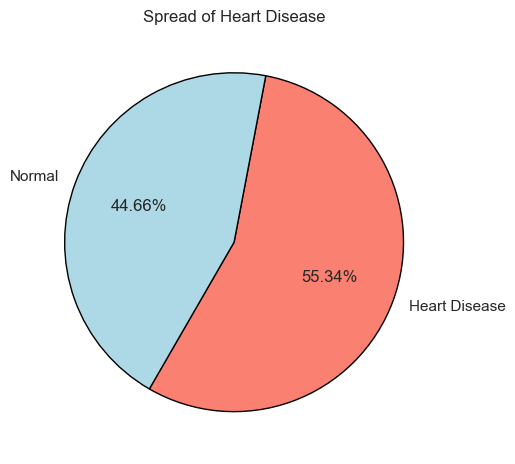

In [767]:
target_values = heart_disease['HeartDisease'].value_counts()

plt.pie(target_values, labels=['Heart Disease', 'Normal'],autopct='%.2f%%',
       startangle=240, colors=['salmon','lightblue'], wedgeprops={'edgecolor':'black','linewidth':1})
plt.title('Spread of Heart Disease')
plt.tight_layout()

> *0 for the min in Cholesterol and RestingBP, is an error in these features, and these will be addressed later on*

In [768]:
heart_disease.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [769]:
heart_disease.describe(include=['O', 'category'])

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,918,918,918,918,918,918,918
unique,2,4,2,3,2,3,2
top,M,ASY,0,Normal,N,Flat,1
freq,725,496,704,552,547,460,508


## Separate Categorical and Numeric Features

In [770]:
cat_features = []
numeric_features = []

for feature in heart_disease.columns:
    if heart_disease[feature].nunique() <= 10:
        cat_features.append(feature)
    else:
        numeric_features.append(feature)

print('Categorical Features:', cat_features)
print('Numeric Features:', numeric_features)

Categorical Features: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
Numeric Features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


In [771]:
cat_features.remove('HeartDisease')

## Visualization

### Categorical Features Histogram

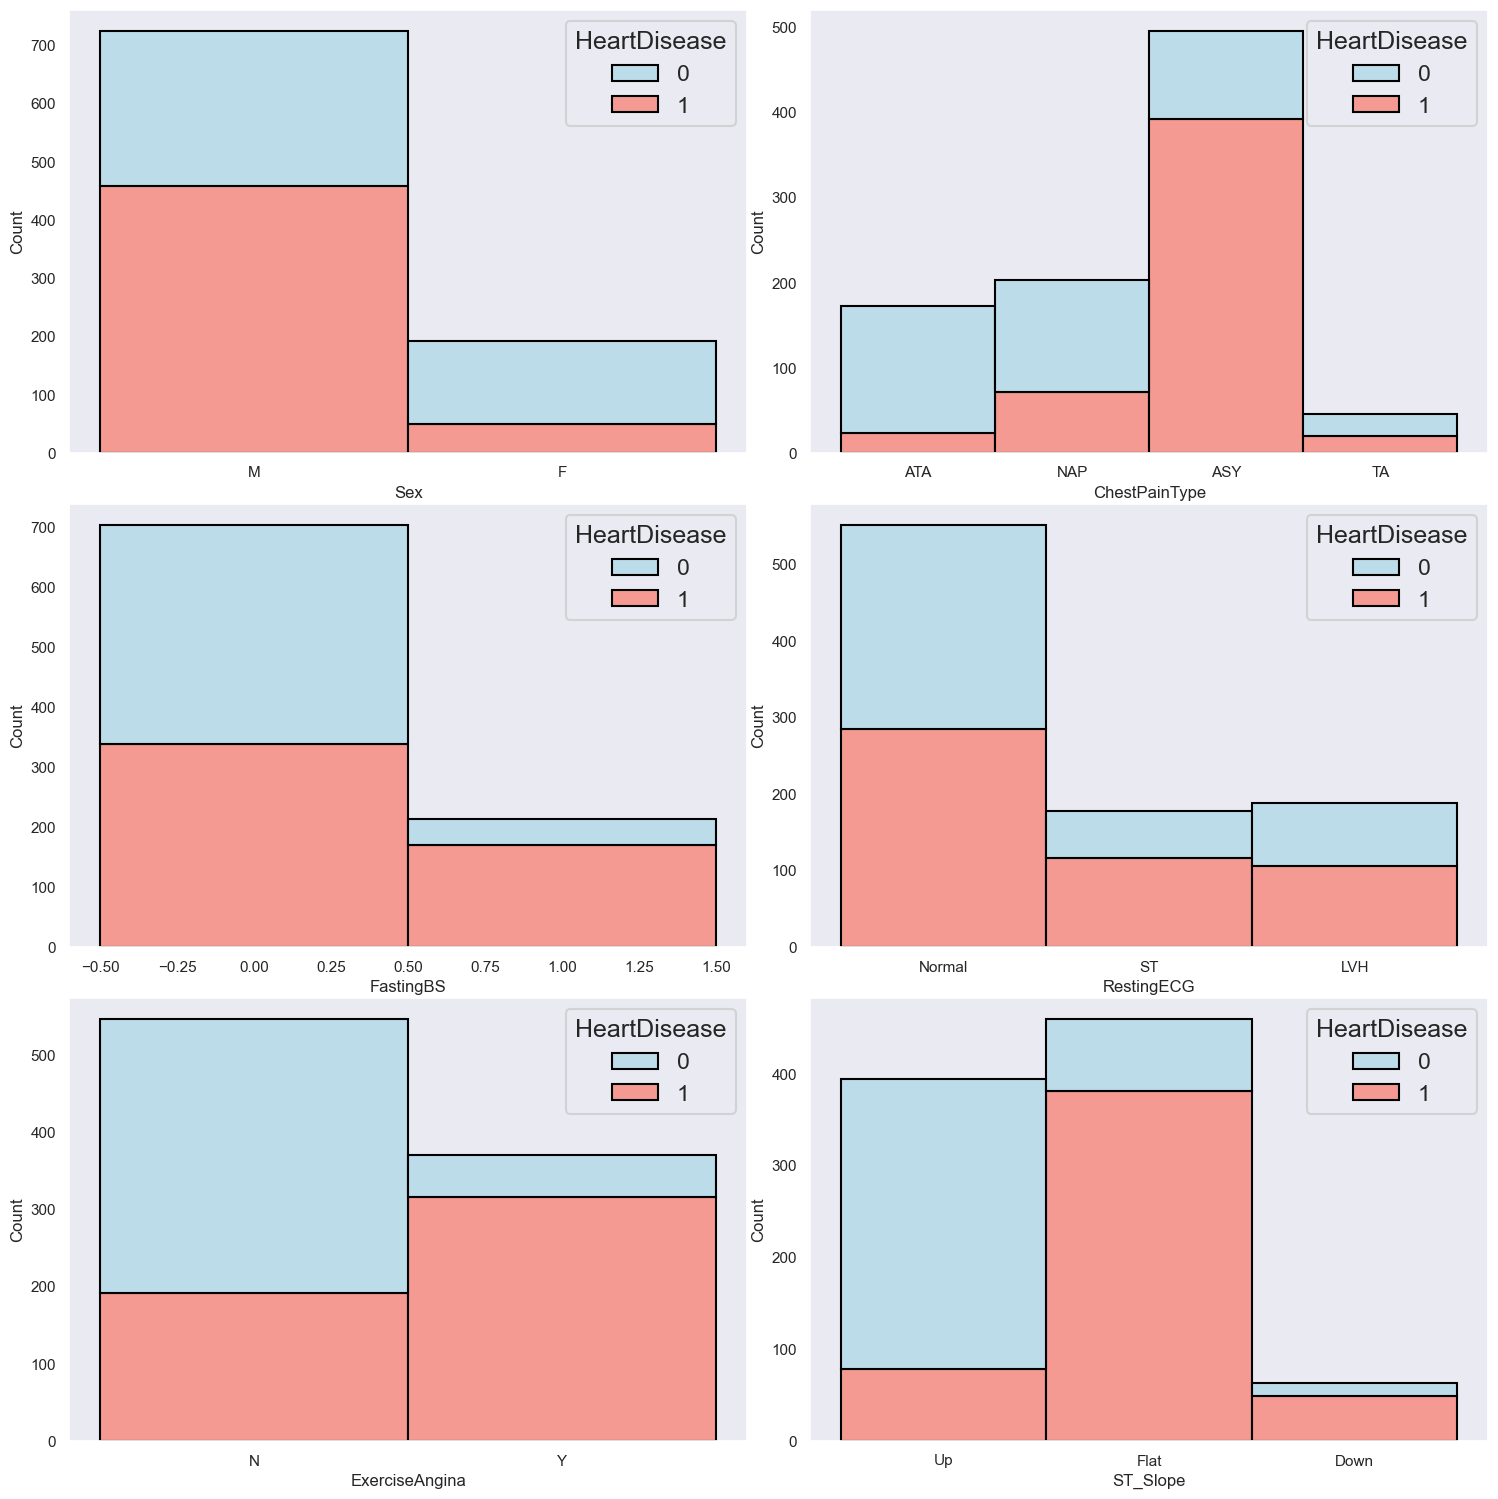

In [772]:
oe = ['lightblue', 'salmon']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

sns.set(style='darkgrid', context='talk')

for i, column in enumerate(cat_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=heart_disease, x=column, hue="HeartDisease", multiple="stack", palette=oe, edgecolor='black')

### Numeric Features Histogram

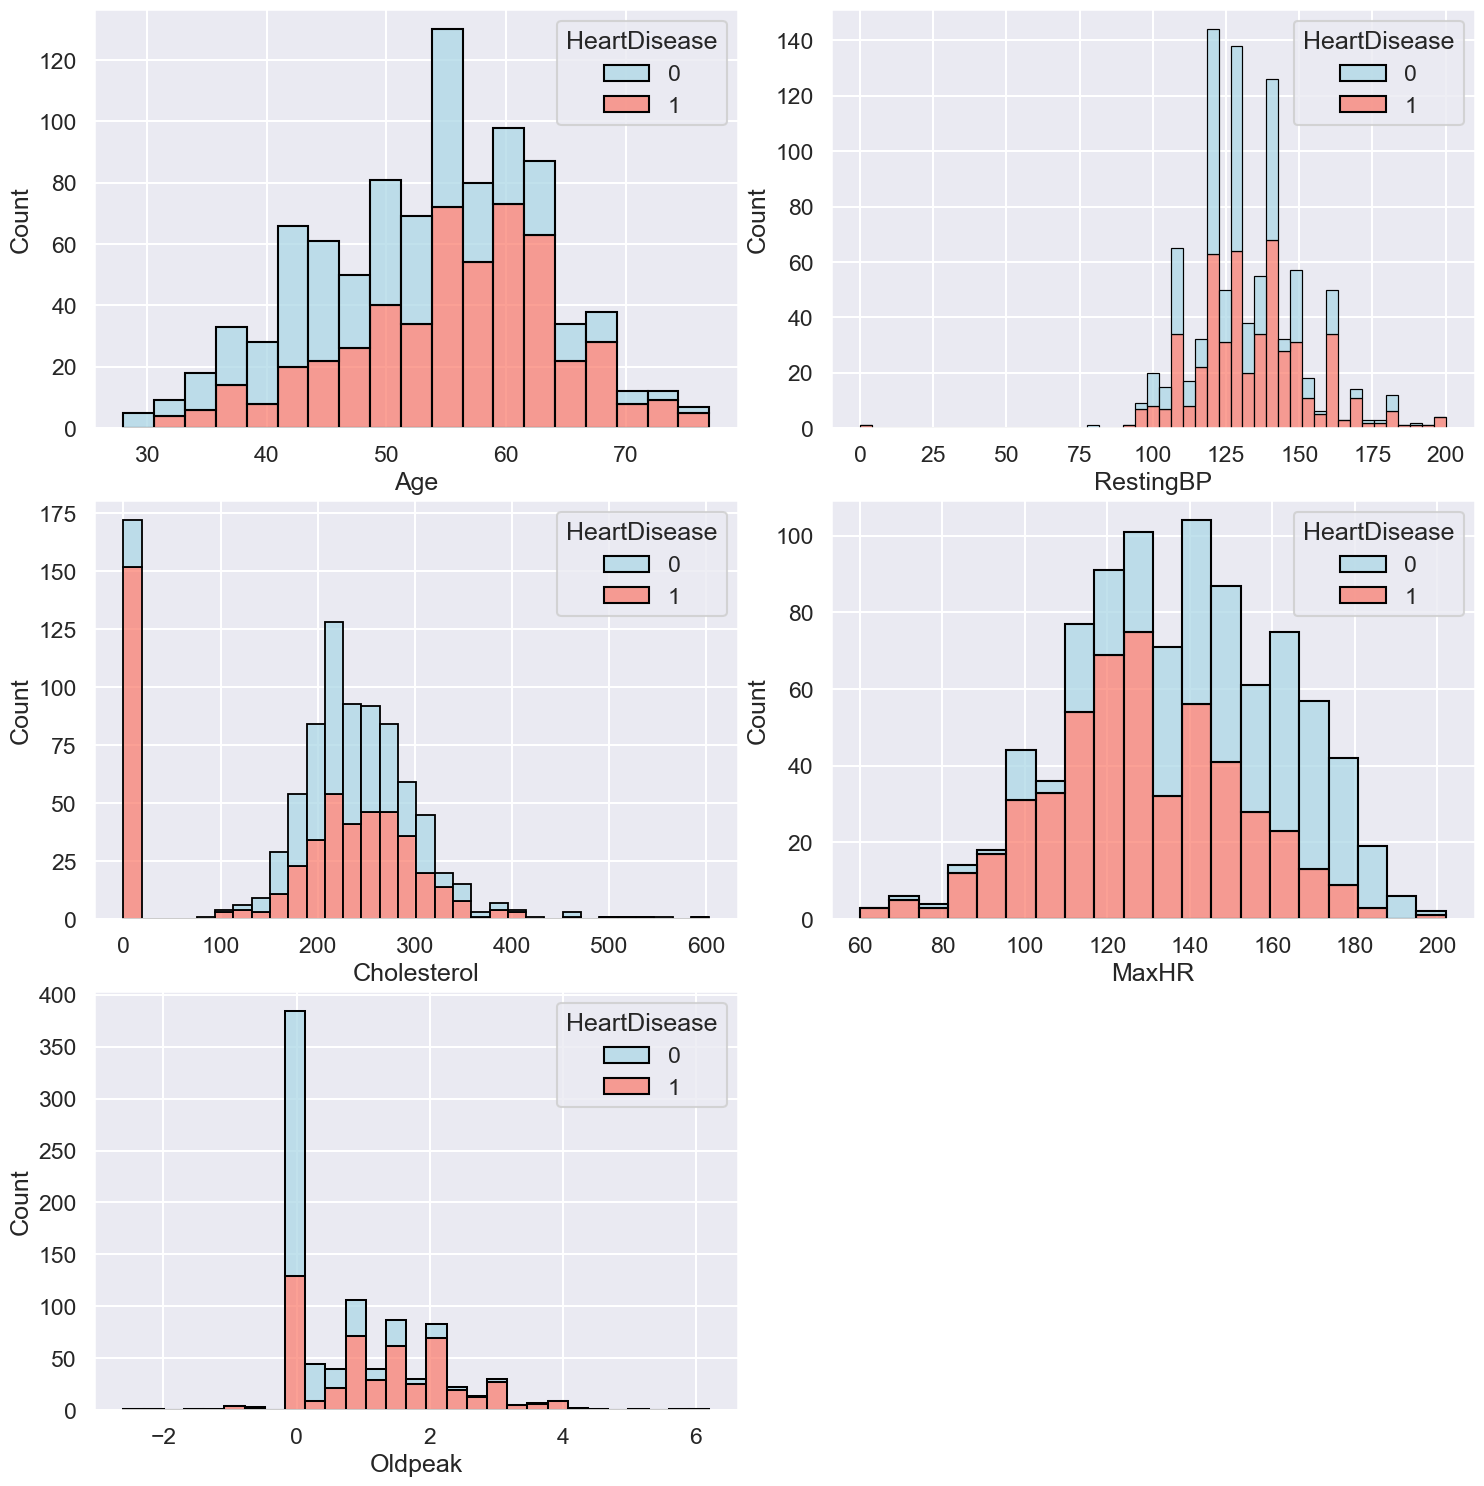

In [773]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

sns.set(style='darkgrid', context='talk')

for i, column in enumerate(numeric_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=heart_disease, x=column, hue="HeartDisease", multiple="stack", palette=oe, edgecolor='black')
    
# remove last empty subplot
if len(numeric_features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

### Numeric Feature's Kernal Density plot

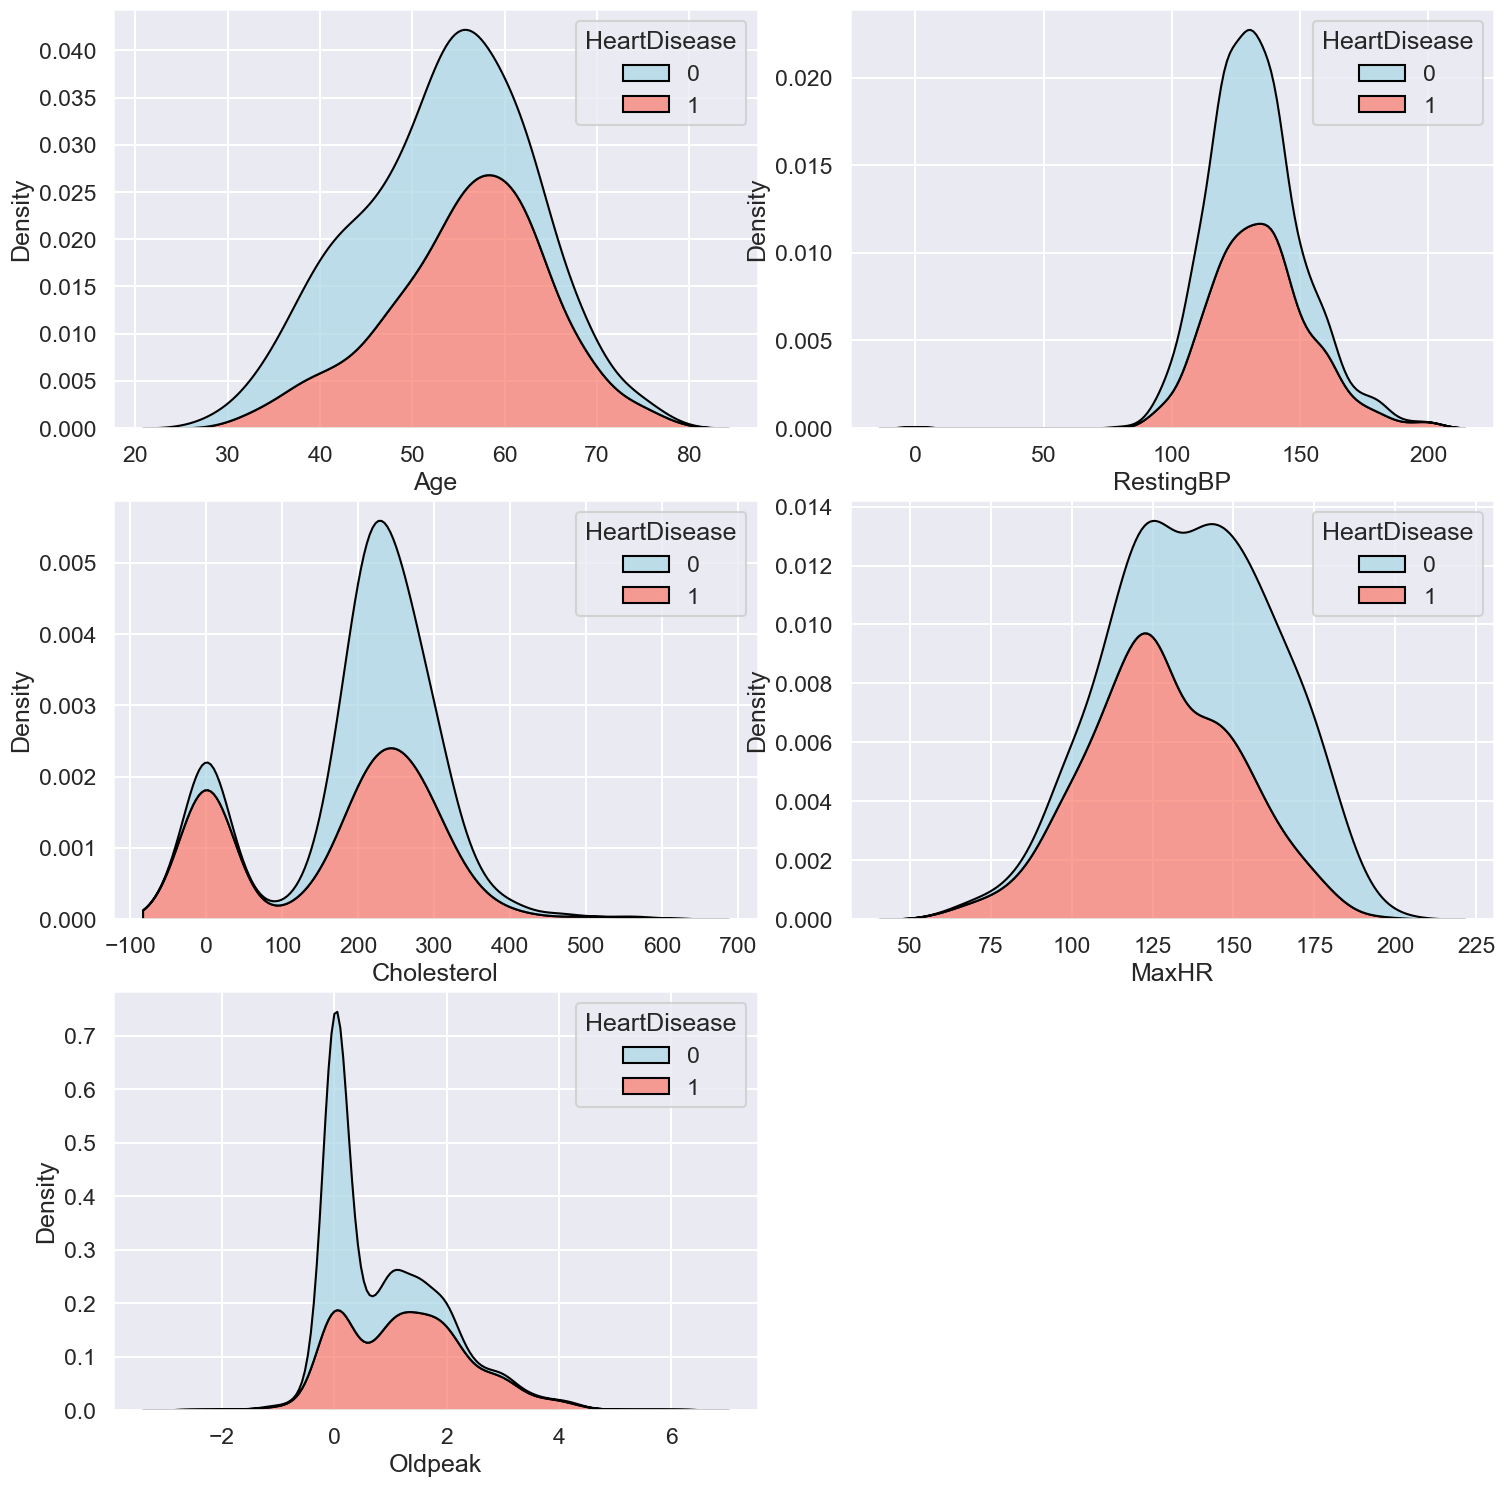

In [774]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

sns.set(style='darkgrid', context='talk')

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=heart_disease, x=feature, hue="HeartDisease", multiple="stack", palette=oe, edgecolor='black')

# remove last empty subplot
if len(numeric_features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

## Possible Mistakes in Data

* From the figures above, we can there are quite a few *cholestrol* values that are *zero*, this is clinically not possible unless these people are dead, which is not the case here since these people have ECG readings.
* also we saw a strange value for *RestingBP* after using the `.describe()` function, that this feature had a `min` value of *zero*, which is also clinically impossible

lets inspect the data that has a Cholestrol or RestingBP of *zero*.

* **Note:** from previous plots, we can see that most of the paitents who have *zero Cholesterol*, have a heart disease (class=1), so the decision will be not to delete them since paitents with a heart disease is what we are trying to understand, and make a model to predict

In [775]:
heart_disease[(heart_disease["Cholesterol"] == 0) | (heart_disease["RestingBP"] == 0)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [776]:
def chol_zero_precense():
    heart_disease.loc[heart_disease["Cholesterol"] == 0, "HeartDisease"].value_counts().plot(kind='bar',
                                                                                             color=['salmon', 'lightblue'], 
                                                                                             edgecolor='black')
    plt.xlabel("Presence of Heart Disease (Cholesterol = 0)")
    plt.ylabel("Count")
    plt.title("Presence of Heart Disease for Patients with Zero Cholesterol")
    plt.show()
    
    corr = heart_disease["Cholesterol"].corr(heart_disease["HeartDisease"])
    print('Correlation between Cholesterol and HeartDisease', corr)

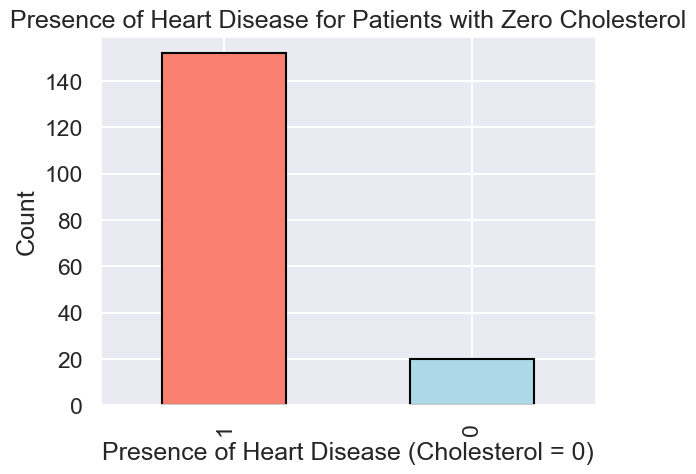

Correlation between Cholesterol and HeartDisease -0.23274063892701133


In [777]:
chol_zero_precense()

> *The Error will have a negative impact on the correlation between Cholesterol and HeartDisease, which is the opposite of what medical reseach implies.*

In [778]:
heart_disease[heart_disease["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


### Handling the mistake in RestingBP
We are going to handle these mistakes as missing values, and replace them with the median value for the RestingBP and create a random forest regressor to predict the values for Cholesterol of each feature

In [779]:
heart_disease["RestingBP"].replace(0, heart_disease["RestingBP"].median(), inplace=True)

## Outlier Detection
Detecting outliers in this problem, is done by boxplots
### Numeric Feature's Boxplot

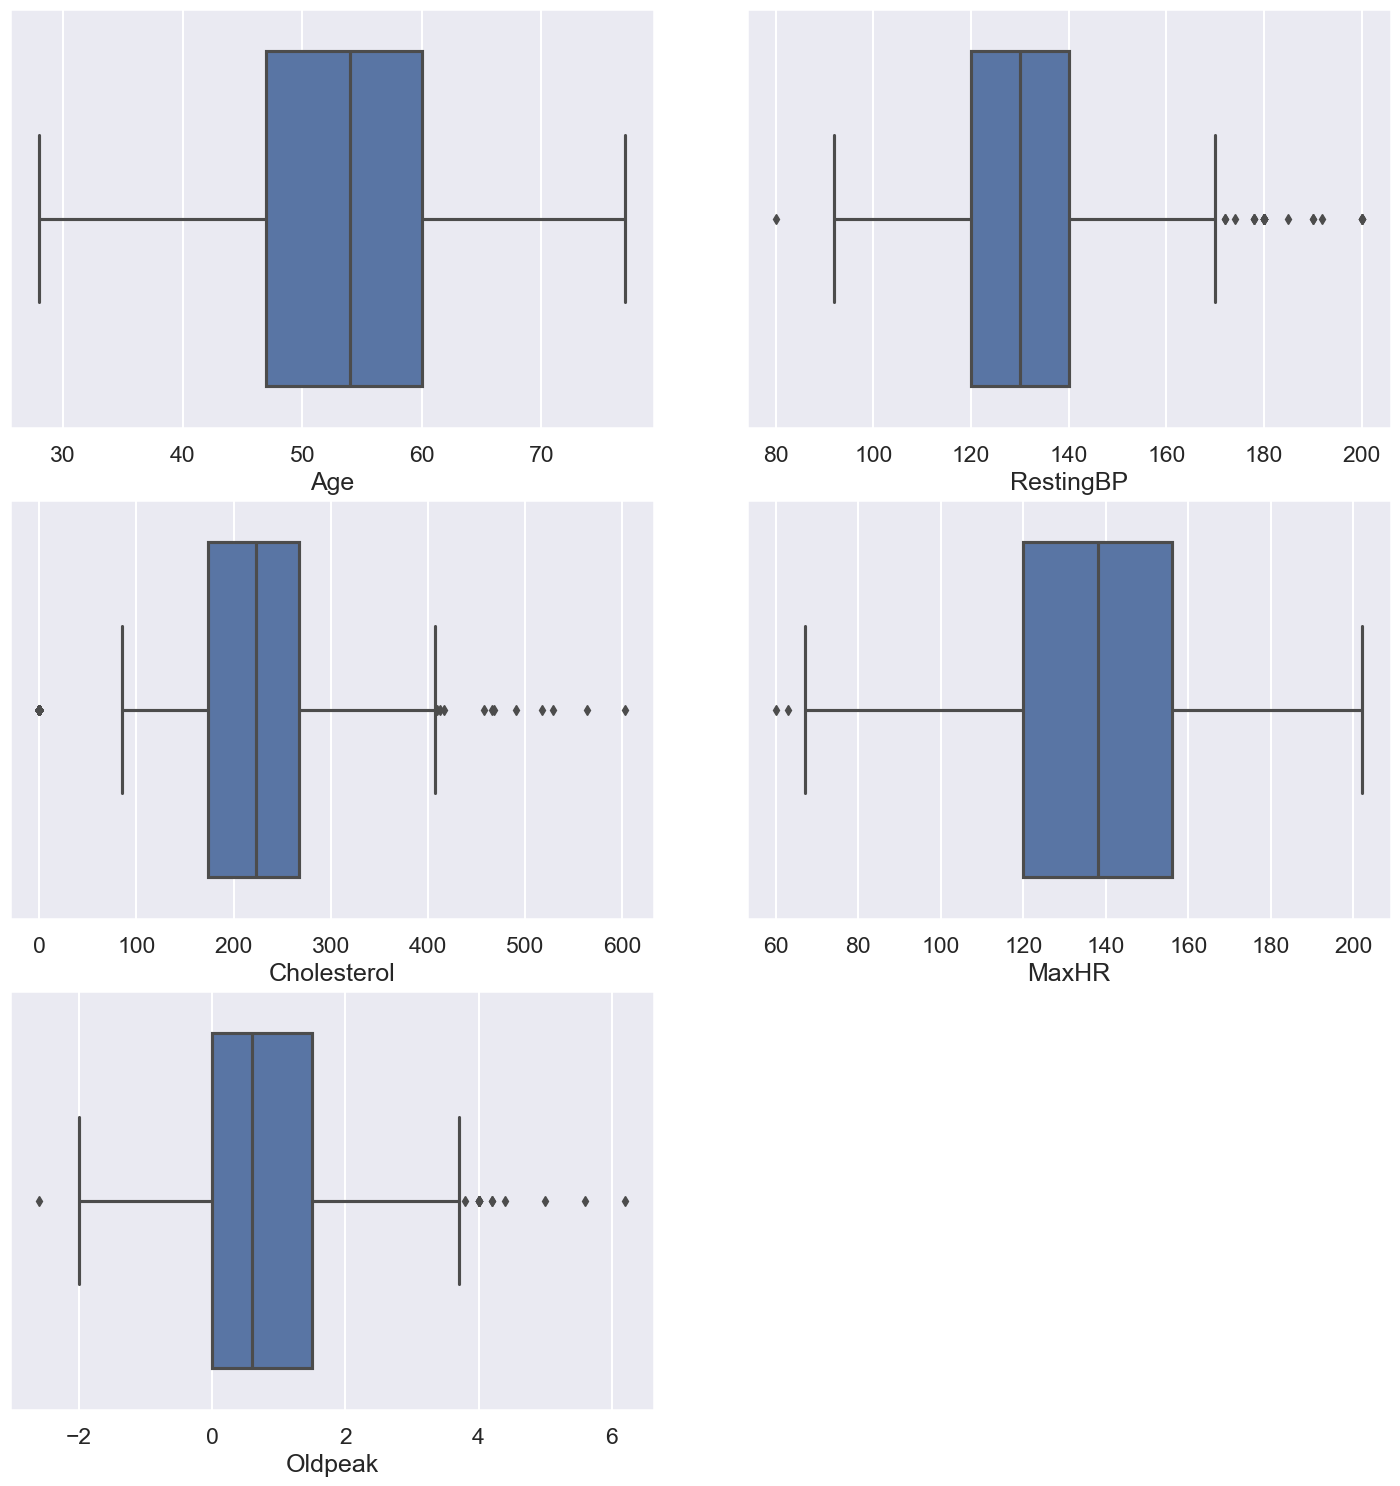

In [780]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.tight_layout()

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=heart_disease, x=feature)

# remove last empty subplot
if len(numeric_features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

---

# Data Preprocessing
## Feature Prepration Before Encoding & Scaling
- Separating Categories into Binary, Non-binary

In [781]:
# separate
binary_features = [feature for feature in cat_features if heart_disease[feature].nunique() == 2]
non_binary_features = [feature for feature in cat_features if 2 < heart_disease[feature].nunique() < 10]

In [782]:
print(binary_features)
print(non_binary_features)

['Sex', 'FastingBS', 'ExerciseAngina']
['ChestPainType', 'RestingECG', 'ST_Slope']


In [783]:
numeric_features.remove("Cholesterol")

## Outlier Handling
The approach used to handle outliers is *Capping*

In [784]:
def outlier_capping(num_features: list):
    for feature in num_features:
        percentile25 = heart_disease[feature].quantile(0.25)
        percentile75 = heart_disease[feature].quantile(0.75)
        iqr = percentile75 - percentile25

        upper_limit = percentile75 + (1.5 * iqr)
        lower_limit = percentile25 - (1.5 * iqr)
        
        heart_disease.loc[heart_disease[feature] > upper_limit, feature] = upper_limit
        heart_disease.loc[heart_disease[feature] < lower_limit, feature] = lower_limit

In [785]:
outlier_capping(["RestingBP", "MaxHR", "Oldpeak"])

## Feature Encoding & Scaling
- *Encode* Categorical features.
- *Scale* Scalar (numeric) features using the *Standard Scalar*.
> **Note**: Cholesterol values are untouched since there are mistakes in input, and will be handled shortly after
- *Merge* all binary, non-binary, and numeric features together into one dataframe

In [786]:
# Encode
ord_enc = OrdinalEncoder()
onehot_enc = OneHotEncoder()

binary_encoded = ord_enc.fit_transform( heart_disease[binary_features] )
non_binary_encoded = onehot_enc.fit_transform( heart_disease[non_binary_features] )

# transform to dataframe
binary_encoded_df = pd.DataFrame(binary_encoded, columns=binary_features)

encoded_feature_names = onehot_enc.get_feature_names_out(non_binary_features)

non_binary_encoded_df = pd.DataFrame(non_binary_encoded.toarray(), columns=encoded_feature_names)

# Scale
scalar = StandardScaler()
scaled_numeric = scalar.fit_transform( heart_disease[numeric_features] )

scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=numeric_features)

In [787]:
heart_disease = pd.concat([binary_encoded_df, non_binary_encoded_df, scaled_numeric_df,
                           heart_disease["Cholesterol"], heart_disease["HeartDisease"]], axis=1)
heart_disease

,Sex,FastingBS,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,MaxHR,Oldpeak,Cholesterol,HeartDisease
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.433140,0.462639,1.384080,-0.851276,289,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.478484,1.644173,0.754610,0.118532,180,1
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.751359,-0.128128,-1.527219,-0.851276,283,0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.584556,0.344485,-1.133801,0.603436,214,1
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.051881,1.053406,-0.583014,-0.851276,195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.902775,-1.309663,-0.189595,0.312494,264,1
914,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.536902,0.698946,0.164482,2.446073,193,1
915,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.370100,-0.128128,-0.858407,0.312494,131,1
916,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.370100,-0.128128,1.462764,-0.851276,236,1


## Imputing Cholesterol Errors (zeros)
1. Replace the zeros with predicted values, using random forest regressor
2. Perform outlier *capping*
3. Scale the feature using *standard* scaling

In [788]:
def fill_missing_chol():
    train_mask = heart_disease["Cholesterol"] != 0
    test_mask = heart_disease["Cholesterol"] == 0
    
    train_set = heart_disease[train_mask]
    test_set = heart_disease[test_mask]
    
    f_train = train_set.drop(columns="Cholesterol")
    output_train = train_set["Cholesterol"]

    f_test = test_set.drop(columns="Cholesterol")
    output_test = test_set["Cholesterol"]
    
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor.fit(f_train, output_train)

    predicted_values = regressor.predict(f_test)
    
    heart_disease.loc[heart_disease["Cholesterol"] == 0, "Cholesterol"] = predicted_values

In [789]:
fill_missing_chol()

In [790]:
outlier_capping(["Cholesterol"])

In [791]:
scaled_chol = scalar.fit_transform(heart_disease[["Cholesterol"]])
heart_disease["Cholesterol"] = scaled_chol

In [792]:
def draw_chol():
    # Create a 1x2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plt.tight_layout()
    plt.subplot(1, 2, 1) 
    sns.histplot(data=heart_disease, x="Cholesterol", hue="HeartDisease", multiple="stack", palette=oe, edgecolor='black')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=heart_disease, x="Cholesterol")

New Correlation: 0.13056595040580535


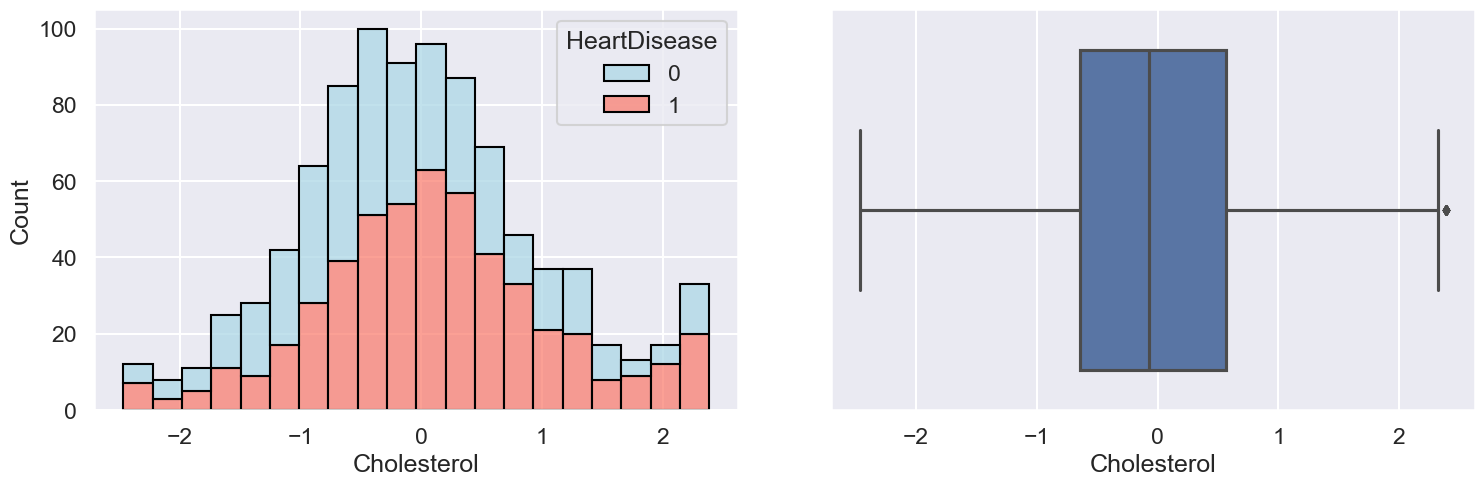

In [793]:
draw_chol()
print('New Correlation:', heart_disease["Cholesterol"].corr(heart_disease["HeartDisease"]))

---

In [794]:
X = heart_disease.drop(columns=["HeartDisease"])
Y = heart_disease["HeartDisease"]

## Train & Test sets split
The split I went for here is a 75/25 split, meaning that **75%** of the dataset is for ***training***, and **25%** is for ***testing***

In [795]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1, stratify=Y)

Text(0.5, 1.0, '230 Testing Instances')

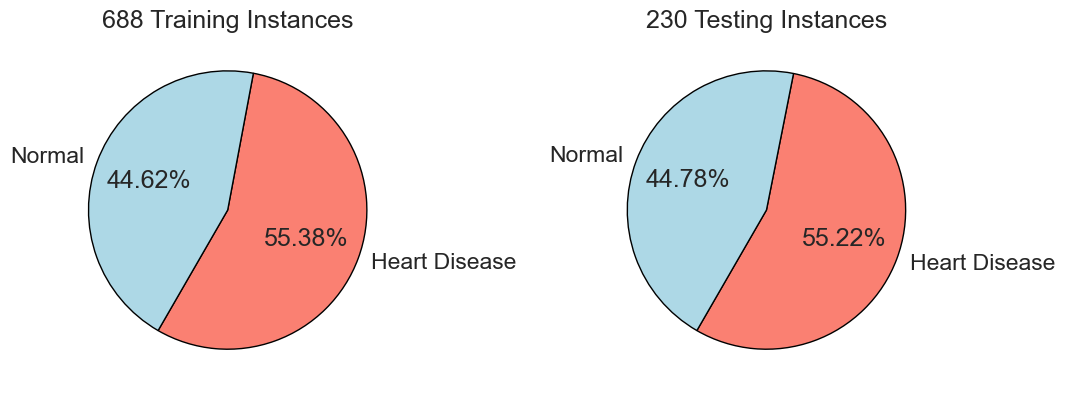

In [796]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.pie(y_train.value_counts(), labels=['Heart Disease', 'Normal'], autopct='%.2f%%',
       startangle=240, colors=['salmon', 'lightblue'], wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title(f'{X_train.shape[0]} Training Instances')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.pie(y_test.value_counts(), labels=['Heart Disease', 'Normal'], autopct='%.2f%%',
       startangle=240, colors=['salmon', 'lightblue'], wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title(f'{X_test.shape[0]} Testing Instances')

---

# Base Model Evaluation
The k-NN classifier is our base model with k set to:
1. k = 1.
2. k = 3.

In [797]:
roc_score = make_scorer(roc_auc_score, needs_threshold=True)

scorers = {
    'roc_auc': roc_score,
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)
}

In [798]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [799]:
for k in [1, 3]:
    knn_model = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    
    scores = cross_validate(knn_model, X_train.values, y_train.values, cv=kfold, scoring=scorers)
    
    roc_auc = scores['test_roc_auc'].mean()
    recall = scores['test_recall'].mean()
    f1 = scores['test_f1'].mean()
    precision = scores['test_precision'].mean()
    accuracy = scores['test_accuracy'].mean()
    
    print('K =', k)
    print('----')
    print(f'ROC_AUC score: %{roc_auc*100: .3f}')
    print(f'recall score: %{recall*100: .3f}')
    print(f'f1 score: %{f1*100: .3f}')
    print(f'precision score: %{precision*100: .3f}')
    print(f'accuracy score: %{accuracy*100: .3f}')
    print('==============')

    del knn_model

K = 1
----
ROC_AUC score: % 79.142
recall score: % 81.087
f1 score: % 81.259
precision score: % 81.584
accuracy score: % 79.363
K = 3
----
ROC_AUC score: % 87.212
recall score: % 89.228
f1 score: % 85.956
precision score: % 82.976
accuracy score: % 83.870


---

# Model Selection & Tuning

## Random Forest Model

### Default Model
First we try the model without any tuning for comparison

In [800]:
def default(model):  
    scores = cross_validate(model, X_train, y_train, cv=kfold, scoring=scorers)
    
    roc_auc = scores['test_roc_auc'].mean()
    recall = scores['test_recall'].mean()
    f1 = scores['test_f1'].mean()
    precision = scores['test_precision'].mean()
    accuracy = scores['test_accuracy'].mean()

    print(f'ROC_AUC score: %{roc_auc*100: .3f}')
    print(f'recall score: %{recall*100: .3f}')
    print(f'f1 score: %{f1*100: .3f}')
    print(f'precision score: %{precision*100: .3f}')
    print(f'accuracy score: %{accuracy*100: .3f}')
    
    return model

In [801]:
rfc = default(RandomForestClassifier(random_state=1))

ROC_AUC score: % 92.429
recall score: % 90.280
f1 score: % 87.854
precision score: % 85.742
accuracy score: % 86.196


### Randomized Search Tuning

In [802]:
def random_search(model, random_grid: dict):
    print(random_grid)
    
    tuning = RandomizedSearchCV(estimator=model, param_distributions=random_grid, scoring='recall',
                                cv=kfold, random_state=1, n_jobs=-1, verbose=3)
    
    tuning.fit(X_train, y_train)
    print('best parameters:', tuning.best_params_)
    print(f'best recall Score Achieved: %{tuning.best_score_*100: .3f}')
        
    return tuning.best_estimator_

In [803]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 800, num = 10)]
max_features = [0.65, 'log2', 'sqrt', None]
max_depth = [5, 10, 20, None]

rf_grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features}

In [804]:
random_rfc = random_search(RandomForestClassifier(random_state=1), rf_grid)

scores = cross_validate(random_rfc, X_train, y_train, cv=kfold, scoring=scorers)

roc_auc = scores['test_roc_auc'].mean()
recall = scores['test_recall'].mean()
f1 = scores['test_f1'].mean()
precision = scores['test_precision'].mean()
accuracy = scores['test_accuracy'].mean()

print(f'ROC_AUC score: %{roc_auc*100: .3f}')
print(f'recall score: %{recall*100: .3f}')
print(f'f1 score: %{f1*100: .3f}')
print(f'precision score: %{precision*100: .3f}')
print(f'accuracy score: %{accuracy*100: .3f}')

{'n_estimators': [50, 133, 216, 300, 383, 466, 550, 633, 716, 800], 'max_depth': [5, 10, 20, None], 'max_features': [0.65, 'log2', 'sqrt', None]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best parameters: {'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 5}
best recall Score Achieved: % 91.593
ROC_AUC score: % 92.838
recall score: % 91.593
f1 score: % 88.593
precision score: % 85.937
accuracy score: % 86.928


### Grid Search Tuning

In [805]:
def grid_search(model, grid: dict):
    print(grid)
    
    tuning = GridSearchCV(estimator=model, param_grid=grid, cv=kfold, n_jobs=-1, verbose=3, scoring='recall')
    
    tuning.fit(X_train, y_train)
    
    print('best parameters:', tuning.best_params_)
    print(f'best recall Score Achieved: %{tuning.best_score_*100: .3f}')
    
    return tuning.best_estimator_

In [806]:
n_estimators = [100, 383, 500, 600]
rf_grid['n_estimators'] = n_estimators

grid_rfc = grid_search(RandomForestClassifier(random_state=1), rf_grid)

scores = cross_validate(grid_rfc, X_train, y_train, cv=kfold, scoring=scorers)

roc_auc = scores['test_roc_auc'].mean()
recall = scores['test_recall'].mean()
f1 = scores['test_f1'].mean()
precision = scores['test_precision'].mean()
accuracy = scores['test_accuracy'].mean()

print(f'ROC_AUC score: %{roc_auc*100: .3f}')
print(f'recall score: %{recall*100: .3f}')
print(f'f1 score: %{f1*100: .3f}')
print(f'precision score: %{precision*100: .3f}')
print(f'accuracy score: %{accuracy*100: .3f}')

{'n_estimators': [100, 383, 500, 600], 'max_depth': [5, 10, 20, None], 'max_features': [0.65, 'log2', 'sqrt', None]}
Fitting 5 folds for each of 64 candidates, totalling 320 fits
best parameters: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
best recall Score Achieved: % 91.852
ROC_AUC score: % 92.654
recall score: % 91.852
f1 score: % 88.621
precision score: % 85.776
accuracy score: % 86.926


---
## Logistic Regression Model

In [807]:
logreg = default(LogisticRegression(random_state=1))

ROC_AUC score: % 92.785
recall score: % 88.975
f1 score: % 88.063
precision score: % 87.322
accuracy score: % 86.632


In [808]:
solver = ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky']
class_weight = [{1: 2, 0: 1}]

grid = {'solver': solver,
        'class_weight': class_weight}

In [809]:
tuned_logreg = grid_search(model=LogisticRegression(random_state=1), grid=grid)

scores = cross_validate(tuned_logreg, X_train, y_train, cv=kfold, scoring=scorers)

roc_auc = scores['test_roc_auc'].mean()
recall = scores['test_recall'].mean()
f1 = scores['test_f1'].mean()
precision = scores['test_precision'].mean()
accuracy = scores['test_accuracy'].mean()

print(f'ROC_AUC score: %{roc_auc*100: .3f}')
print(f'recall score: %{recall*100: .3f}')
print(f'f1 score: %{f1*100: .3f}')
print(f'precision score: %{precision*100: .3f}')
print(f'accuracy score: %{accuracy*100: .3f}')

{'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky'], 'class_weight': [{1: 2, 0: 1}]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best parameters: {'class_weight': {1: 2, 0: 1}, 'solver': 'liblinear'}
best recall Score Achieved: % 92.902
ROC_AUC score: % 92.799
recall score: % 92.902
f1 score: % 87.961
precision score: % 83.749
accuracy score: % 85.906


### The Chosen Model
>- The chosen model is the ***tuned Logistic Regression model***, since it resulted in higher recall, while also maintaining High ROC_AUC

- Both Random Forest Classifier, and Logistic Regression model performed very well, the tuned Logistic regression model had a higher recall (2%), but a lower precesion (3%)

# Testing Model & Performence Analysis

In [810]:
best_model = tuned_logreg

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [811]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Recall: %{recall*100: .3f}')
print(f'precision: %{precision*100: .3f}')
print(f'Accuracy: %{accuracy*100: .3f}')
print(f'F1: %{f1*100: .3f}')

Recall: % 94.488
precision: % 80.000
Accuracy: % 83.913
F1: % 86.643


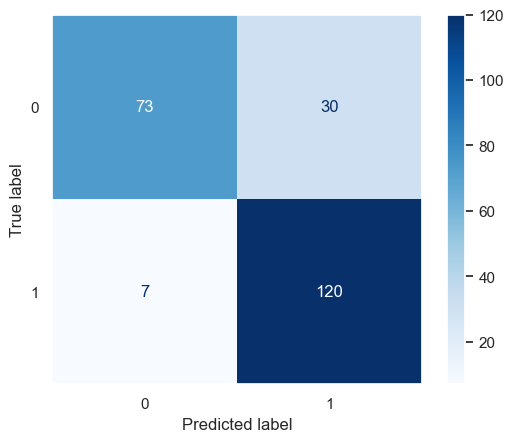

In [812]:
sns.set(style='dark')

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix without the decision threshold grid
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')

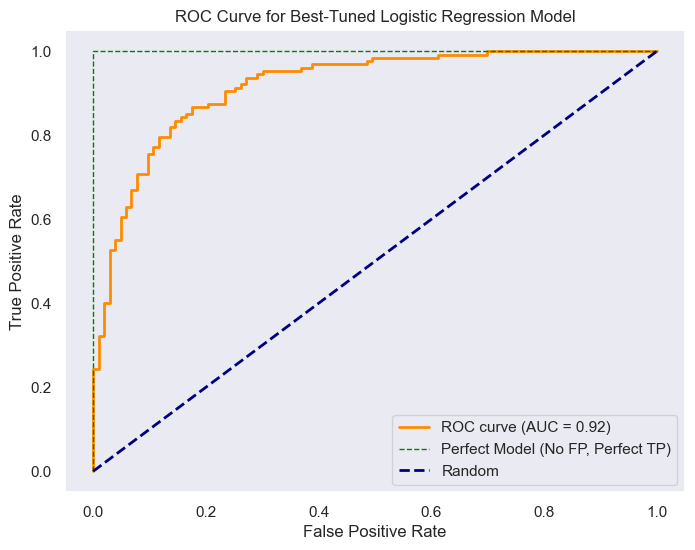

In [813]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 0, 1], [0, 1, 1], color='green', lw=1, linestyle='--', label='Perfect Model (No FP, Perfect TP)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best-Tuned Logistic Regression Model')
plt.legend(loc='lower right')
plt.show()


In [831]:
misclassified_indices = np.where(y_test != y_pred)[0]
misclassified_instances = X_test.iloc[misclassified_indices].copy()

true_labels = y_test.iloc[misclassified_indices]
predicted_labels = y_pred[misclassified_indices]

misclassified_instances["predicted_labels"] = predicted_labels
misclassified_instances["true_labels"] = true_labels

misclassified_instances[misclassified_instances["true_labels"] == 1].describe()

,Sex,FastingBS,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Age,RestingBP,MaxHR,Oldpeak,Cholesterol,predicted_labels
count,7.0,7.0,7.0,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.000000,7.0,7.0,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.0
mean,1.0,0.0,0.0,0.428571,0.142857,0.428571,0.0,0.428571,0.428571,0.142857,0.0,0.0,1.0,-0.266338,-0.381314,1.221092,-0.435644,0.319922,0.0
std,0.0,0.0,0.0,0.534522,0.377964,0.534522,0.0,0.534522,0.534522,0.377964,0.0,0.0,0.0,0.742510,1.344440,0.642221,1.099660,0.964123,0.0
min,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,-1.008848,-1.427816,0.597242,-0.851276,-0.981087,0.0
25%,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,-0.849739,-1.250586,0.734939,-0.851276,-0.222514,0.0
50%,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,-0.160265,-1.191509,0.911978,-0.851276,-0.019279,0.0
75%,1.0,0.0,0.0,1.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.0,0.0,1.0,-0.054192,0.108179,1.639802,-0.851276,0.890256,0.0
max,1.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.0,1.112610,2.234940,2.288944,2.058149,1.904336,0.0
